# Real Time Twitter Streamming for Topics of Your Interest 

<img src="Twitter_2010_logo.png" alt="drawing" style="width: 800px;"/>

## Hashtags are an effective way to get more eyes (and engagement!) 
Using targeted hashtags on your posts is one of the best ways to get discovered by new audiences. And this can translate into more engagement, more followers, and more customers for your business.

# Find Your Top Performing Hashtags with Spark Streaming
<img src="twitter-strategy.png" style="width: 700px;"/>

### The structure of streamming analysis
<img src="structure.png" style="width: 450px;"/>

In [1]:
import time
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

In [2]:
#step1
from ipywidgets import widgets
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc
#create sc and connect to the streaming api
sc = SparkContext()
ssc = StreamingContext(sc, 10 )
sqlContext = SQLContext(sc)

In [3]:
#step2 connect streaming socket
socket_stream = ssc.socketTextStream("127.0.0.1", 5550)#should use the same connection with the .py file
lines = socket_stream.window( 30 )#streaming window

In [4]:
#step3 #generate temporary table : tweets
from collections import namedtuple
fields = ("tag", "count" )
Tweet = namedtuple( 'Tweet', fields )

### Choose: @ or #? 

In [5]:
#step4
tag = str(input('Type the tag kind you want to find: @ or #  ? '))

Type the tag kind you want to find: @ or #  ? #


In [6]:
#step5 pyspark processing
( lines.flatMap( lambda text: text.split( " " ) ) #Splits to a list
  .filter( lambda word: word.lower().startswith(tag) ) # Checks for hashtag calls
  .map( lambda word: ( word.lower(), 1 ) ) # Lower cases the word
  .reduceByKey( lambda a, b: a + b ) # Reduces
  .map( lambda rec: Tweet( rec[0], rec[1] ) ) # Stores in a Tweet Object
  .foreachRDD( lambda rdd: rdd.toDF().sort( desc("count") ) # Sorts Them in a DF
  .limit(10).registerTempTable("tweets") ) ) # Registers to a table.

In [7]:
topic = str(input("What topic you want to track? "))
%store topic

What topic you want to track? san francisco
Stored 'topic' (str)


### Connect streaming data
<img src="trending.png" alt="drawing" style="width: 700px;"/>

In [8]:
#step6 start sc
ssc.start()    

# Visualization

In [9]:
#Please wait 20 seconds - to get enough data for visualization
#step8 
def findtag(tag=tag,timerange = 60):
    count = 0
    tophash = []
    while count < round(timerange/5):
        time.sleep( 5 )
        top_10_tweets = sqlContext.sql( 'Select tag, count from tweets' )
        #print(top_10_tweets)
        top_10_df = top_10_tweets.toPandas()
        #bar plot
        display.clear_output(wait=True)
        plt.figure( figsize = (12,8) )
        sns.barplot( x="count", y="tag", data=top_10_df).set_title('top10 {} tag every 5 seconds'.format(tag))
        plt.show()
        tophash = tophash + top_10_df['tag'].apply(lambda x: x.split(tag)[-1]).values.T.tolist()
        count += 1
    return (tophash)

In [ ]:
toptag=findtag(tag=tag) 

## Word Cloud

In [15]:
from wordcloud import WordCloud
#define wordcloud function
def printwordcould(top = toptag, tag = tag ,timerange = 60):
    wordcloud = WordCloud(background_color='white',
                              max_words=200,
                              max_font_size=20, 
                              random_state=42
                             ).generate(' '.join(top))
    print(wordcloud)
    fig = plt.figure(figsize=(12,8))
    sns.set()
    plt.imshow(wordcloud)
    plt.title('Top {} during {} seconds'.format(tag, timerange), fontsize=40)
    plt.axis('off')
    plt.show()

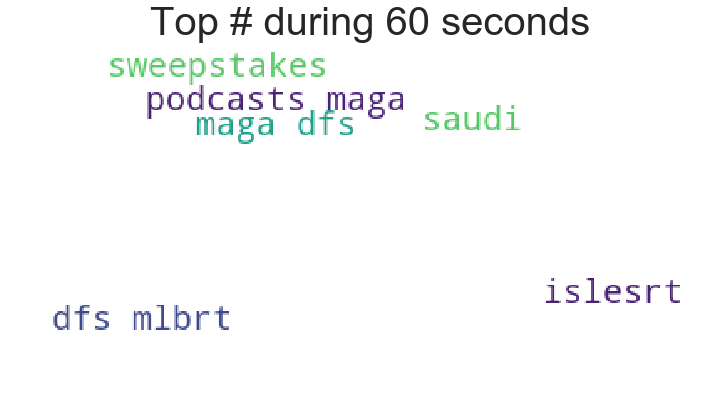

In [16]:
printwordcould(top = toptag,tag =  tag)

In [16]:
topic = 'amazon'

In [17]:

from collections import Counter
def findtoptag(n=10):
    wordcount = Counter(toptag,sorted=True)
    w = wordcount.most_common(n)
    keys = []
    return [''.join('#'+item[0]) for item in w]

### Hashtags you want to add to your post are:

In [ ]:
n = input('Type how many tags you want to add? ')
print('Your top {} hashtags: {}'.format(n, topic, ' '.join(findtoptag())))

### You can copy the output directly to your twitter post to attract more eyes!!

<img src="thanks.jpg" alt="drawing" style="width: 1000px;"/>

In [19]:
ssc.stop()